<a href="https://colab.research.google.com/github/gizdatalab/CPU/blob/main/dataset/Step6/CWIKI_Dataset_Stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we will update the, Published dataset for Subtargets: NetzeroLabel, GHGLabel, NonGHGLabel with Annotated datasets. Finally we will look at statistics of data at Classifiers(classifiers are developed in multilabel framework with some hierarchy)

In [ ]:
! pip install datasets huggingface_hub

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from datasets import load_dataset
import datasets
import numpy as np
import pandas as pd

# Load and Update Data

In [ ]:
# repo_id = "GIZ/policy_classification"
# data_files={"train": "policy_classification_train.json",
#                                            "test": "policy_classification_test.json"}
# dataset = load_dataset(repo_id, data_files=data_files,
#                                           token=True)

In [ ]:
import json
path_to_folder = '/content/drive/MyDrive/Colab Notebooks/CPU/dataset/Step5/output/'
data = pd.read_json(path_to_folder + 'policy_classification.json')

In [ ]:
# method to get the count of each Label Category, revealing how many
# True, False and None category we have
def boolvalidate(data, col):
    print('Total count', len(data))
    print('{} count'.format(col), sum(data[col] == True),
          'Non {} count'.format(col), sum(data[col]==False))
    print('Missig values', sum(data[col].isna()))

def check_bool_unique(df):
    # sometimes when saving the dataframe as json, since Label can have True, False
    # and None, the boolean values get imputed with True >> 1.0 and False >> 0.0
    label_col = list(df.columns)
    label_col = list(filter(lambda x: 'Label' in x, label_col))
    label_col = list(set(label_col) - {'SectorLabel','SubSectorLabel'})
    for label in label_col:
        print(label,df[label].unique())

In [ ]:
def prepare_multilabel_df(df, cols):
    """
    Takes the dataframe and list of columns which need to combined into
    One-hot-encoded labels.

    """
    df = df.copy()
    df.dropna(subset = cols, inplace=True)
    df = df.reset_index(drop=True)
    df['labels'] = df.apply(lambda x: [int(x[label]) for label in cols],axis=1)
    # we have multilingual dataset ('en', 'fr','es'), in case of non-english the
    # translated Context is udner the column 'TranslatedContext'. We impute these
    # back into 'context' to work with only English dataset.
    df['Context'] = df.apply(lambda x: x['Context'] if x['Language'] == 'en'
                                    else x['TranslatedContext'][0],axis=1)
    df.rename(columns = {'Context':'text'}, inplace=True)

    df = df[['text','labels']+cols]
    return df

In [ ]:
check_bool_unique(data)

GHGLabel [nan  0.  1.]
NetzeroLabel [nan  0.  1.]
ConditionalLabel [ True False]
MitigationLabel [ True False]
PolicyLabel [ 0.  1. nan]
UnconditionalLabel [False  True]
PlansLabel [ 1.  0. nan]
ActionLabel [ 0.  1. nan]
AdaptationLabel [False  True]
NonGHGLabel [nan  0.  1.]
TargetLabel [ 1.  0. nan]


## Update << Annotated Data

In [ ]:
import json
path_to_folder = '/content/drive/MyDrive/Colab Notebooks/CPU/Annotation/'
annotated_data = pd.read_json(path_to_folder + 'subtarget_annotated.json')
# getting annotation based on status, setting up dictionary with key as text,
# and annotation as values
annotated_data['annotation'] = annotated_data.apply(lambda x:x['annotation']
                                 if x['status'] == 'Validated' else None,axis=1)
annotated_data['split'] = annotated_data.metadata.apply(lambda x:x['split'])
annotated_data = annotated_data[['text','annotation', 'split']]
text_label_dict = dict(zip(annotated_data['text'],annotated_data['annotation']))

In [ ]:
label_names= ['GHGLabel','NetzeroLabel','NonGHGLabel']
label_names.sort()

# separating out dataframe which is annotated and part which doesnt need update
# from annotated data
sub_target_indexes = list(data.dropna(subset = label_names)\
                          .query("TargetLabel == True").index.values)
# dataframe which will be updated with subtarget annotation
sub_target_df = data[data.index.isin(sub_target_indexes)]
# dataframe which remains unaffected from annotations
df = data.drop(sub_target_df.index)

In [ ]:
sub_target_df = sub_target_df.reset_index(drop=True)
# annotation are done using only English Context (Union[Context, TranslatedContext])
sub_target_df['text'] = sub_target_df.apply(lambda x: x['Context']
                            if x['Language']=='en' else x['TranslatedContext'][0],axis=1)
sub_target_df['subtargets'] = sub_target_df.apply(lambda x: text_label_dict[x['text']],axis=1)

# updating the sub target labels
label_names= ['GHGLabel','NetzeroLabel','NonGHGLabel']
label_names.sort()
for label in label_names:
  sub_target_df[label] = sub_target_df.subtargets.apply(lambda x: None if x is None else
                                             (True if label in x else False))

In [ ]:
# metrics are same as in Annotation tool
boolvalidate(sub_target_df,'NetzeroLabel')
boolvalidate(sub_target_df,'GHGLabel')
boolvalidate(sub_target_df,'NonGHGLabel')

Total count 844
NetzeroLabel count 133 Non NetzeroLabel count 696
Missig values 15
Total count 844
GHGLabel count 500 Non GHGLabel count 329
Missig values 15
Total count 844
NonGHGLabel count 298 Non NonGHGLabel count 531
Missig values 15


In [ ]:
# updating labels in remaining dataframe
df = df.reset_index(drop=True)
for label in label_names:
  df[label] = None
sub_target_df.drop(columns = ['text','subtargets'],inplace=True)
data = pd.concat([df,sub_target_df],ignore_index=True)

In [ ]:
train_df = data[data.split == 'Train'].reset_index(drop=True)
test_df = data[data.split == 'Test'].reset_index(drop=True)

# Update the test dataset

In [ ]:
train_df['Document'] = train_df['Document'].apply(lambda x:list(set(x)))
test_df['Document'] = test_df['Document'].apply(lambda x:list(set(x)))

In [ ]:
from difflib import SequenceMatcher
def find_matchpercentage(string1,alpha3, document, df):
    temp =  df[df.Alpha3 == alpha3].reset_index(drop=True)
    temp = temp[temp.Document.astype(str).str.contains(document)].reset_index(drop=True)
    list_ = list(temp.Context)
    placeholder = []
    for string2 in list_:
      placeholder.append(SequenceMatcher(None,string1,string2).ratio())
    return max(placeholder)

In [ ]:
test_df['check'] = test_df.apply(lambda x: find_matchpercentage(x['Context'],
                                                                x['Alpha3'],
                                                                x['Document'][0],
                                                                train_df),axis=1)

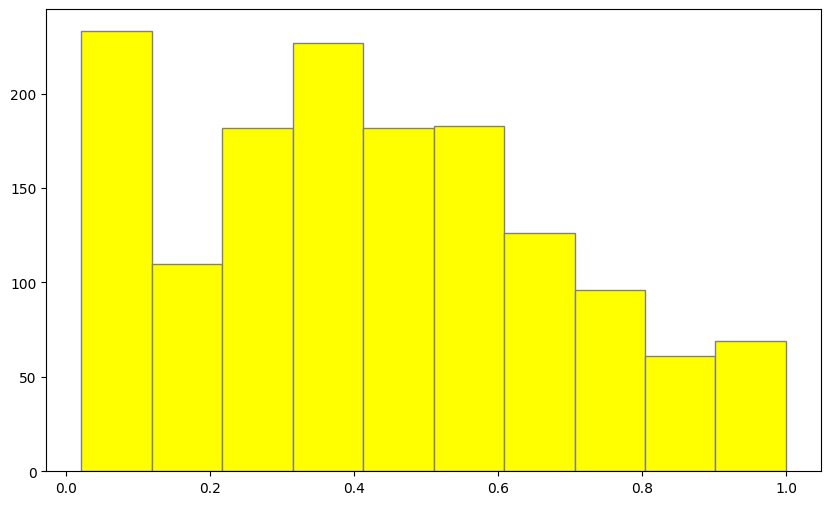

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize = (10,6))
counts, bins, patches = ax.hist(test_df.check, facecolor='yellow',edgecolor='gray')

In [ ]:
test_df = test_df[test_df.check < 0.66]
test_df.drop(columns = ['check'],inplace=True)
test_df =test_df.reset_index(drop=True)

# TAPP Information

In [ ]:
print("The TAPP Labels Information in Training Data \n")
boolvalidate(train_df,'TargetLabel')
boolvalidate(train_df,'ActionLabel')
boolvalidate(train_df,'PolicyLabel')
boolvalidate(train_df,'PlansLabel')

The TAPP Labels Information in Training Data 

Total count 12538
TargetLabel count 3611 Non TargetLabel count 8886
Missig values 41
Total count 12538
ActionLabel count 5426 Non ActionLabel count 4669
Missig values 2443
Total count 12538
PolicyLabel count 1399 Non PolicyLabel count 8695
Missig values 2444
Total count 12538
PlansLabel count 2151 Non PlansLabel count 7972
Missig values 2415


In [ ]:
label_names= ['TargetLabel','ActionLabel','PlansLabel','PolicyLabel']
tapp_train = prepare_multilabel_df(train_df, label_names)
print('\n','Classes Representation in TAPP Training Dataset:',len(tapp_train))
for i,label in enumerate(label_names):
    print(i,".",label, ":", sum( [x[i] for x in list(tapp_train['labels'])]))


 Classes Representation in TAPP Training Dataset: 10031
0 . TargetLabel : 2911
1 . ActionLabel : 5416
2 . PlansLabel : 2140
3 . PolicyLabel : 1396


In [ ]:
print("The TAPP Labels Information in Test Data \n")
boolvalidate(test_df,'TargetLabel')
boolvalidate(test_df,'ActionLabel')
boolvalidate(test_df,'PolicyLabel')
boolvalidate(test_df,'PlansLabel')

The TAPP Labels Information in Test Data 

Total count 1190
TargetLabel count 335 Non TargetLabel count 853
Missig values 2
Total count 1190
ActionLabel count 513 Non ActionLabel count 421
Missig values 256
Total count 1190
PolicyLabel count 125 Non PolicyLabel count 811
Missig values 254
Total count 1190
PlansLabel count 200 Non PlansLabel count 736
Missig values 254


In [ ]:
label_names= ['TargetLabel','ActionLabel','PlansLabel','PolicyLabel']
tapp_test = prepare_multilabel_df(test_df, label_names)
print('\n','Classes Representation in TAPP Test Dataset:',len(tapp_test))
for i,label in enumerate(label_names):
    print(i,".",label, ":", sum( [x[i] for x in list(tapp_test['labels'])]))


 Classes Representation in TAPP Test Dataset: 932
0 . TargetLabel : 256
1 . ActionLabel : 513
2 . PlansLabel : 198
3 . PolicyLabel : 122


# AdapMit Information

In [ ]:
print("The ADAPMIT Labels Information in Training Data \n")
boolvalidate(train_df,'AdaptationLabel')
boolvalidate(train_df,'MitigationLabel')

The ADAPMIT Labels Information in Training Data 

Total count 12538
AdaptationLabel count 5439 Non AdaptationLabel count 7099
Missig values 0
Total count 12538
MitigationLabel count 6659 Non MitigationLabel count 5879
Missig values 0


In [ ]:
label_names= ['AdaptationLabel','MitigationLabel']
adapmit_train = prepare_multilabel_df(train_df, label_names)
print('\n','Classes Representation in ADAPMIT Training Dataset:',len(adapmit_train))
for i,label in enumerate(label_names):
    print(i,".",label, ":", sum( [x[i] for x in list(adapmit_train['labels'])]))


 Classes Representation in ADAPMIT Training Dataset: 12538
0 . AdaptationLabel : 5439
1 . MitigationLabel : 6659


In [ ]:
print("The ADAPMIT Labels Information in Test Data \n")
boolvalidate(test_df,'AdaptationLabel')
boolvalidate(test_df,'MitigationLabel')

The ADAPMIT Labels Information in Test Data 

Total count 1190
AdaptationLabel count 533 Non AdaptationLabel count 657
Missig values 0
Total count 1190
MitigationLabel count 604 Non MitigationLabel count 586
Missig values 0


In [ ]:
label_names= ['AdaptationLabel','MitigationLabel']
adapmit_test = prepare_multilabel_df(test_df, label_names)
print('\n','Classes Representation in ADAPMIT Training Dataset:',len(adapmit_test))
for i,label in enumerate(label_names):
    print(i,".",label, ":", sum( [x[i] for x in list(adapmit_test['labels'])]))


 Classes Representation in ADAPMIT Training Dataset: 1190
0 . AdaptationLabel : 533
1 . MitigationLabel : 604


# Conditionality Information

In [ ]:
print("The Conditional Labels Information in Training Data \n")
boolvalidate(train_df,'ConditionalLabel')
boolvalidate(train_df,'UnconditionalLabel')

The Conditional Labels Information in Training Data 

Total count 12538
ConditionalLabel count 1986 Non ConditionalLabel count 10552
Missig values 0
Total count 12538
UnconditionalLabel count 1312 Non UnconditionalLabel count 11226
Missig values 0


In [ ]:
print("The Conditional Labels Information in Test Data \n")
boolvalidate(test_df,'ConditionalLabel')
boolvalidate(test_df,'UnconditionalLabel')

The Conditional Labels Information in Test Data 

Total count 1190
ConditionalLabel count 192 Non ConditionalLabel count 998
Missig values 0
Total count 1190
UnconditionalLabel count 136 Non UnconditionalLabel count 1054
Missig values 0


In [ ]:
# # given the high imbalance in positive and negative examples, we downsample the
# # negative examples
data = train_df.copy()
data['check'] = data.apply(lambda x: True if (x['UnconditionalLabel'] == True)
                          or (x['ConditionalLabel'] == True) else False,axis=1)
temp = data[data.check==True].reset_index(drop=True)
print(len(temp))
temp2 = data[data.check ==False].reset_index(drop=True).sample(frac= 0.3, random_state=42)
print(len(temp2))
df = pd.concat([temp,temp2], ignore_index=True)
# conditional_train = df[df.split== 'Train'].reset_index(drop=True)
# conditional_test = df[df.split=='Test'].reset_index(drop=True)

3056
2845


In [ ]:
label_names= ['ConditionalLabel','UnconditionalLabel']
conditional_train = prepare_multilabel_df(df, label_names)
print('\n','Classes Representation in Conditionality Training Dataset:',len(conditional_train))
for i,label in enumerate(label_names):
    print(i,".",label, ":", sum( [x[i] for x in list(conditional_train['labels'])]))


 Classes Representation in Conditionality Training Dataset: 5901
0 . ConditionalLabel : 1986
1 . UnconditionalLabel : 1312


# Subtarget Information

In [ ]:
print("The Subtarget Labels Information in Training Data \n")
boolvalidate(train_df,'NetzeroLabel')
boolvalidate(train_df,'GHGLabel')
boolvalidate(train_df,'NonGHGLabel')

The Subtarget Labels Information in Training Data 

Total count 12538
NetzeroLabel count 120 Non NetzeroLabel count 608
Missig values 11810
Total count 12538
GHGLabel count 440 Non GHGLabel count 288
Missig values 11810
Total count 12538
NonGHGLabel count 259 Non NonGHGLabel count 469
Missig values 11810


In [ ]:
print("The Subtarget Labels Information in Test Data \n")
boolvalidate(test_df,'NetzeroLabel')
boolvalidate(test_df,'GHGLabel')
boolvalidate(test_df,'NonGHGLabel')

The Subtarget Labels Information in Test Data 

Total count 1190
NetzeroLabel count 11 Non NetzeroLabel count 69
Missig values 1110
Total count 1190
GHGLabel count 49 Non GHGLabel count 31
Missig values 1110
Total count 1190
NonGHGLabel count 30 Non NonGHGLabel count 50
Missig values 1110


In [ ]:
label_names= ['NetzeroLabel','GHGLabel','NonGHGLabel']
sub_train = prepare_multilabel_df(train_df, label_names)
print('\n','Classes Representation in Sub-Targets Training Dataset:',len(sub_train))
for i,label in enumerate(label_names):
    print(i,".",label, ":", sum( [x[i] for x in list(sub_train['labels'])]))


 Classes Representation in Sub-Targets Training Dataset: 728
0 . NetzeroLabel : 120
1 . GHGLabel : 440
2 . NonGHGLabel : 259


In [ ]:
sub_test = prepare_multilabel_df(test_df, label_names)
print('\n','Classes Representation in Sub-Targets Test Dataset:',len(sub_test))
for i,label in enumerate(label_names):
    print(i,".",label, ":", sum( [x[i] for x in list(sub_test['labels'])]))


 Classes Representation in Sub-Targets Test Dataset: 80
0 . NetzeroLabel : 11
1 . GHGLabel : 49
2 . NonGHGLabel : 30


# Sector Information

In [ ]:
# sector data is not True/False, but a multilabel setting where if sector is
# included is part of List
sector_train_df = train_df.dropna(subset = ['SectorLabel']).reset_index(drop=True)
sector_test_df = test_df.dropna(subset = ['SectorLabel']).reset_index(drop=True)
sector_list = [val  for list_ in list(sector_train_df.SectorLabel) for val in list_]
sector_list = list(set(sector_list))

for sector in sector_list:
    sector_train_df[sector] = sector_train_df.SectorLabel.apply(lambda x: True
                                                      if sector in x else False)
    sector_test_df[sector] = sector_test_df.SectorLabel.apply(lambda x: True
                                                      if sector in x else False)

# sector_train_df = sector_data[sector_data.split== 'Train'].reset_index(drop=True)
# sector_test_df = sector_data[sector_data.split=='Test'].reset_index(drop=True)

# creating multilabel dataset
label_names=sector_list
label_names.sort()
sector_train_df = prepare_multilabel_df(sector_train_df, label_names)
sector_test_df = prepare_multilabel_df(sector_test_df, label_names)

In [ ]:
print('\n','Classes Representation in Training Dataset:',len(sector_train_df))
for i,label in enumerate(label_names):
    print(i,".",label, ":", sum( [x[i] for x in list(sector_train_df['labels'])]))


 Classes Representation in Training Dataset: 10123
0 . Agriculture : 2235
1 . Buildings : 169
2 . Coastal Zone : 698
3 . Cross-Cutting Area : 1853
4 . Disaster Risk Management (DRM) : 814
5 . Economy-wide : 873
6 . Education : 180
7 . Energy : 2847
8 . Environment : 905
9 . Health : 662
10 . Industries : 419
11 . LULUCF/Forestry : 1861
12 . Social Development : 507
13 . Tourism : 192
14 . Transport : 1173
15 . Urban : 558
16 . Waste : 714
17 . Water : 1207


In [ ]:
print('\n','Classes Representation in Test Dataset:',len(sector_test_df))
for i,label in enumerate(label_names):
    print(i,".",label, ":", sum( [x[i] for x in list(sector_test_df['labels'])]))


 Classes Representation in Test Dataset: 936
0 . Agriculture : 200
1 . Buildings : 18
2 . Coastal Zone : 71
3 . Cross-Cutting Area : 180
4 . Disaster Risk Management (DRM) : 85
5 . Economy-wide : 85
6 . Education : 23
7 . Energy : 254
8 . Environment : 91
9 . Health : 68
10 . Industries : 41
11 . LULUCF/Forestry : 193
12 . Social Development : 56
13 . Tourism : 28
14 . Transport : 107
15 . Urban : 51
16 . Waste : 59
17 . Water : 106


# Push changes to Dataset

In [ ]:
print("Size of Training data", (len(train_df)))
print("Size of Test data", (len(test_df)))
data = pd.concat([train_df, test_df], ignore_index = True)
print("total size of data", len(data))

Size of Training data 12538
Size of Test data 1190
total size of data 13728


In [ ]:
# # save the to be published dataset
import json
jsonfile = data.to_json(orient="records")
parsed = json.loads(jsonfile)
path_to_step6 = "/content/drive/MyDrive/Colab Notebooks/CPU/dataset/Step6/"
with open(path_to_step6+ 'output/policy_classification.json', 'w') as file:
    json.dump(parsed, file, indent=4)

data.to_csv(path_to_step6 + 'output/policy_classification.csv')

In [ ]:
train_df.drop(columns = ['split'],inplace=True)
test_df.drop(columns = ['split'],inplace=True)

In [ ]:
# # save the to be published dataset
import json
jsonfile = train_df.to_json(orient="records")
parsed = json.loads(jsonfile)
path_to_step6 = "/content/drive/MyDrive/Colab Notebooks/CPU/dataset/Step6/"
with open(path_to_step6+ 'output/policy_classification_train.json', 'w') as file:
    json.dump(parsed, file, indent=4)


jsonfile = test_df.to_json(orient="records")
parsed = json.loads(jsonfile)
path_to_step6 = "/content/drive/MyDrive/Colab Notebooks/CPU/dataset/Step6/"
with open(path_to_step6+ 'output/policy_classification_test.json', 'w') as file:
    json.dump(parsed, file, indent=4)
